In [347]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다.

from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

import matplotlib.pyplot as plt


In [348]:
data=pd.read_csv(r'C:\Users\BM\Downloads\iris.csv', index_col=0)
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica


In [349]:
X = data.drop('Species', axis=1).to_numpy() #target인 종을 제외한 값들을 넘파이 배열로
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

In [350]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
target=data['Species']

encoder = LabelEncoder()
encoder.fit(target)
Y_encoder=encoder.transform(target)

Y = np_utils.to_categorical(Y_encoder)
# 범주형 데이터로 나뉘어져 있는 Y값을 labelencoder를 통해 100 010 001 식의 넘파이 배열로 전처리
# keras에서 했던 과정이라 확인 생략

In [351]:
## 데이터를 tensor 형태로 변환
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.LongTensor(y_data) # y는 longtype으로 변환필요.. CrossEntropyLoss issue..
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [352]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [353]:
X_train[1]

array([0.58333333, 0.375     , 0.55932203, 0.5       ])

In [354]:
X_test[1]

array([0.5       , 0.33333333, 0.62711864, 0.45833333])

In [355]:
Y_train[1]

array([0., 1., 0.], dtype=float32)

In [356]:
class cf(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(4, 50, bias=True) #입력층 4개
        self.fc2 = nn.Linear(50, 50, bias=True) 
        self.fc3 = nn.Linear(50, 3, bias=True) #output은 3개범주
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x))) 
        x = self.fc3(x) # output 활성화 함수 softmax 인데 crossentorpy 에는 softmax 포함돼있으니까 안해도된다.
      
        return x

In [357]:
model = cf()
criterion = nn.CrossEntropyLoss() # loss function은 crossentropy로, crossentorpy 에는 softmax 포함돼있으니까 안해도된다.

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) 

In [358]:
print(model)

cf(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [359]:
from torch.autograd import Variable
loss_ = []
acc_=[]
n = len(trainloader)

for epoch in range(300): # 300 epoch 진행

    running_loss, total, correct = 0.0 ,0.0, 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        inputs ,values = data


        optimizer.zero_grad() 
        
        outputs = model(inputs) 
        loss = criterion(outputs, torch.max(values, 1)[1]) # output 과 input=values, dim 1의 longtensor값 crossentropy  
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
        
    
    
        _, predicted = torch.max(outputs.data, 1)
        new_values=torch.max(values,1)[1]
        correct += (predicted == new_values).sum().item()
        total += values.size(0) # 개수 누적(총 개수)
    loss_.append(running_loss/n)    
    acc_.append(100 *correct/total)
print('Finished Training')

Finished Training


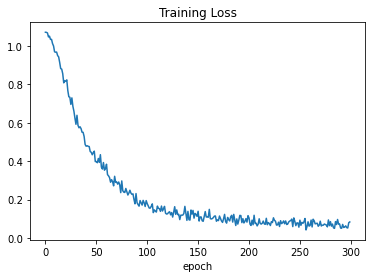

In [360]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

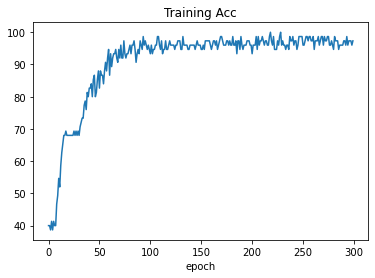

In [361]:
plt.plot(acc_)
plt.title("Training Acc")
plt.xlabel("epoch")
plt.show()

In [290]:
predicted

tensor([2, 0, 2, 0, 0, 1, 1, 2, 2, 1, 2])

In [296]:
values

tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]])

In [299]:
torch.max(values,1)

torch.return_types.max(
values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
indices=tensor([2, 0, 2, 0, 0, 1, 1, 2, 2, 1, 1]))

In [362]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, values = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        new_values=torch.max(values,1)[1]
        correct += (predicted == new_values).sum().item()
        total += values.size(0) # 개수 누적(총 개수)
accuracy = ((100 * correct / total))

In [363]:
print('Accuracy: {:.4f}'.format(accuracy))

Accuracy: 97.3333
